In [1]:
from utils.config import Project_Config, CIFAR_10_Config, CIFAR_10_Local_Config
from utils.custom_enums import Dataset_Type_Enum
project_config = Project_Config()

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [2]:
dataset_type = Dataset_Type_Enum.CIFAR2
SAVE=False
f = project_config.folder_symbol
save_path = (
    project_config.PWD + f +
    "DINO" + f +
    f"dino_{dataset_type}.pt"
)

In [3]:
if dataset_type == Dataset_Type_Enum.CIFAR2:
    dataset_config = CIFAR_10_Local_Config(
        project_config=project_config,
        dataset_type=dataset_type
    )
if dataset_type == Dataset_Type_Enum.CIFAR10:
    dataset_config = CIFAR_10_Config()

In [4]:
dataset_config.dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'label_txt': Value(dtype='string', id=None)}

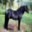

In [5]:
dataset_config.dataset[0]["image"]

In [6]:
dataset_config.dataset[0]["label_txt"]

'horse'

In [7]:
from transformers import AutoImageProcessor, Dinov2Model

import torch

image = dataset_config.dataset[0]["image"]

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

model = Dinov2Model.from_pretrained("facebook/dinov2-base")

dataset_size = len(dataset_config.dataset)

if SAVE:

    set_size = 1000
    last_hidden_states = torch.zeros(dataset_size,257,768)

    for i in range(0,dataset_size//set_size):
        a=i*set_size
        b=(i+1)*set_size

        input_set = image_processor(dataset_config.dataset[a:b]["image"], return_tensors="pt")

        with torch.no_grad():
            outputs = model(**input_set)

        last_hidden_states[a:b] = outputs.last_hidden_state
        print(f"Completed {(i+1)*set_size} of {dataset_size} images")

    print(list(last_hidden_states.shape))

    torch.save(last_hidden_states, save_path)

In [8]:
pregenerated_dino_results = torch.load(save_path)
print(list(pregenerated_dino_results.shape))

pregenerated_dino_results = pregenerated_dino_results.reshape(dataset_size,257*768)

/tmp/ipykernel_206751/3449114581.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pregenerated_dino_results = torch.load(save_path)


[5000, 257, 768]


In [9]:
image = dataset_config.dataset[100]["image"]
input_image = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**input_image)

last_hidden_state = outputs.last_hidden_state

last_hidden_state = last_hidden_state.reshape(1,257*768)

print(last_hidden_state.shape)
print(pregenerated_dino_results.shape)

cosine_similarity = torch.nn.CosineSimilarity(dim=1)

c = torch.zeros(1,dataset_size)

set_size = 1000

for i in range(0,dataset_size//set_size):
    a=i*set_size
    b=(i+1)*set_size

    c[0,a:b] = cosine_similarity(last_hidden_state,pregenerated_dino_results[a:b])

print(c.shape)
print(c)
print(torch.argmax(c))

torch.Size([1, 197376])
torch.Size([5000, 197376])
torch.Size([1, 5000])
tensor([[0.1532, 0.3845, 0.3042,  ..., 0.1183, 0.1330, 0.1407]])
tensor(100)


tensor([ 100, 3238,  445, 3342, 2901, 4418, 4578, 1099, 1533, 3605])


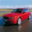

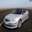

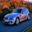

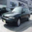

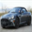

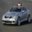

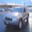

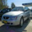

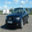

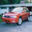

In [10]:
best_matches = torch.flatten(torch.topk(c,10).indices)
print(best_matches)

for i in range(10):
    display(dataset_config.dataset["image"][best_matches[i]])